# Introduction

This notebook explores the shapelet transformers implemented within aeon. For a wider understanding please refer to antoines notebook first.

if you want to learn about x y z then go to antoines

here youll learn about a b c

# A little bit about each transformer
- talk generally about the purpose of transforms as opposed to shapelet trees
- talk about their params and logic and contributions and flaws (write in order of release)

In [1]:
import warnings
warnings.filterwarnings('ignore')

from aeon.registry import all_estimators

for k, v in all_estimators("transformer", filter_tags={"algorithm_type": "shapelet"}):
    print(f"{k}: {v}")    ## TODO: SAST is not appearing here for some reason - I locally changed the tag (not making a commit for it to avoid PR conflicts)

RSAST: <class 'aeon.transformations.collection.shapelet_based._rsast.RSAST'>
RandomDilatedShapeletTransform: <class 'aeon.transformations.collection.shapelet_based._dilated_shapelet_transform.RandomDilatedShapeletTransform'>
RandomShapeletTransform: <class 'aeon.transformations.collection.shapelet_based._shapelet_transform.RandomShapeletTransform'>


## Shapelet transform

## Random Dilated Shapelet Transform

## Scalable and Accurate Subsequence Transform

## Random Scalable and Accurate Subsequence Transform

# The Gun/No Gun classification problem

The Gun/NoGun motion capture time series dataset is perhaps the most studied time
series classification problem in the literature.

This dataset involves one female actor and one male actor making a motion with their hand, sometimes holding a gun and sometimes not. The classification problem is to determine whether or not they were holding a prop or just miming the action. The problem is made somewhat more complicated by the fact that the two actors, differ in height (by 12 inches) and “style”.

The two classes are:

Gun-Draw:
- the actors have their hands by their sides. They draw a replicate gun from a hip-mounted holster, point it at a target for approximately one second, then return the gun to the holster, and their hands to their sides. 

Point:
- the actors have their gun by their sides. They point with their index fingers to a target for approximately one second, and then return their hands to their sides. 

For both classes, they study tracked the centroid of the actor's right hand in both X- and Y-axes, which appear to be highly correlated. Because of this, the data in the archive is just the X-axis - making this a univariate time series. Class 1 is "gun" and class 2 is "no gun (pointing)".

In [2]:
from aeon.datasets import load_classification
import numpy as np

X_gun_train, y_gun_train = load_classification("GunPoint", split="train")
X_gun_test, y_gun_test = load_classification("GunPoint", split="test")

X_gun_full = np.concatenate((X_gun_train, X_gun_test), axis=0)

print(f"Shape of the dataset: {X_gun_full.shape}")
print(f"Number of channels = {X_gun_train.shape[1]}")
print(f"Length of each time series = {X_gun_train.shape[2]}")
print(f"Number of training samples = {X_gun_train.shape[0]}")
print(f"Number of testing samples = {X_gun_test.shape[0]}")

Shape of the dataset: (200, 1, 150)
Number of channels = 1
Length of each time series = 150
Number of training samples = 50
Number of testing samples = 150


As you can see, we have 200 different time series, each 150 datapoints long. The train/test split follows the original paper with 50 samples taken for training and the rest for testing, with each actor and class being equally represented in each. 

Note: Time series classification follows its on train/test split rather than the more general 70/30 found in wider ML. Eamonn, who was setting up the archive, chose to make the train sets smaller so that the classification problems would even harder to solve!

---


The two graphs below have the time series from the dataset plotted for each class.

*can we find a big difference between class 1 and 2?*  ---- The narrative will be that the data is noisy and so trying to use global patterns would make this pretty hard, instead shapelets will let us find locally discriminative subsequences to distinguish the two

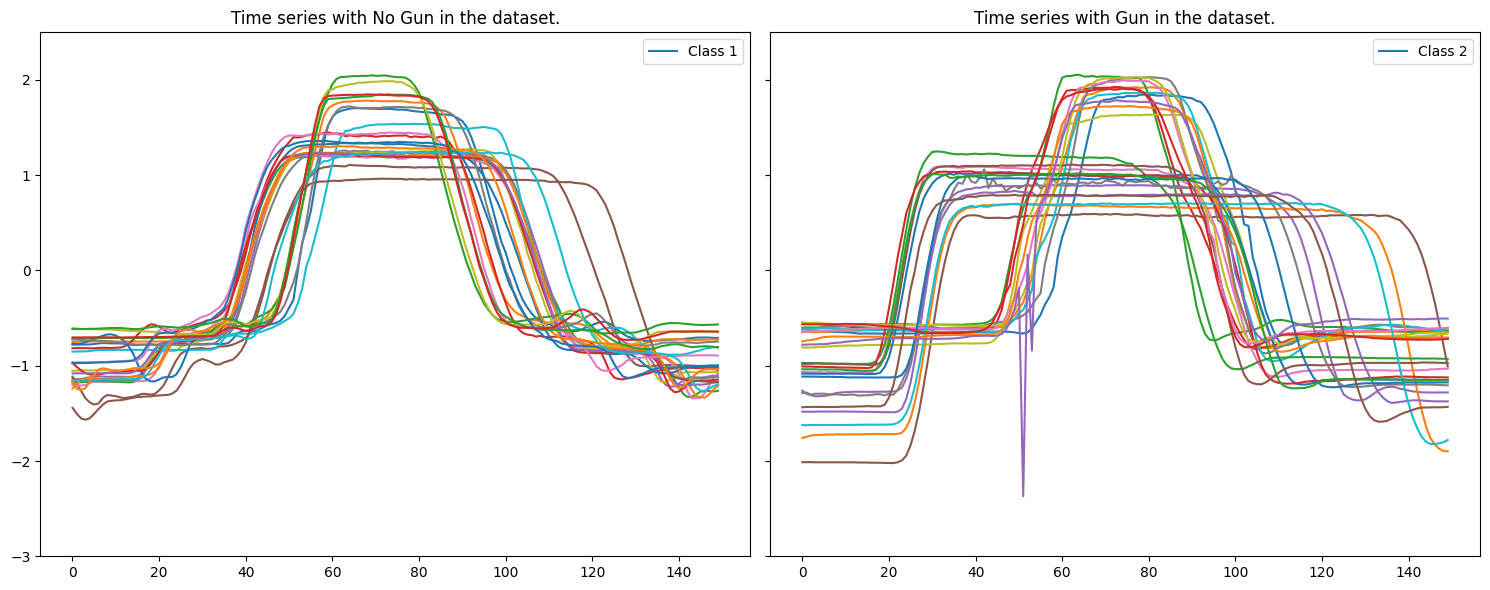

In [3]:
import matplotlib.pyplot as plt

class_1_indices = []
class_2_indices = []

# Populate the class-specific lists
for i in range(0, 50):
    if y_gun_train[i] == '1':
        class_1_indices.append(i)
    elif y_gun_train[i] == '2':
        class_2_indices.append(i)

# Create a figure arranged horizontally
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot the first class
for i in class_1_indices:
    axs[0].plot(X_gun_train[i][0])
axs[0].set_title("Time series with No Gun in the dataset.")
axs[0].set_ylim(-3, 2.5)  # Set the y-axis range for comparability
axs[0].legend(['Class 1'])

# Plot the second class
for i in class_2_indices:
    axs[1].plot(X_gun_train[i][0])
axs[1].set_title("Time series with Gun in the dataset.")
axs[1].set_ylim(-3, 2.5)  # Set the y-axis range for comparability
axs[1].legend(['Class 2'])

plt.tight_layout()
plt.show()


You can roughly make out the groups of time series of the female and male actor, as described in the dataset the male is 12 inches taller which can be seen by the taller and shorter time series groups

# Discuss how we will explore the transform, compare them, and hopefully understand something about the motion data

- track how long it takes to fit the transform
- show the head of a pandas df to explain how the transform looks
- generate 10 shapelets for each transform and plot all 10 on a graph, keep their positions (dont just layer them)
- choose a shapelet for each class and do the three plots from the visualisation tool
    - provide some insights on these

- compare the shapelets
    - compare their lengths
    - going to fit a classifier to help us rank shapelets

- run through different transformers with different configurations
    - this is an optional extension (i think the above is a sufficient NB)
        - maybe if we can obviously improve a transform with some parameter then do so

- Note: useful visualisation tools are ShapeletVisualizer, ShapeletTransformVisualizer

# Fitting the Transforms to the training data

#### Random Shapelet Transform

The aeon implementation of the algorithm matches the experimental parameters explored in the Gunpoint problem, the only parameter which was required to be set was max_shapelets = 10. 

The paper filtered the GunPoint data set using the
length parameters specified in the original shapelet paper to allow for
a fair comparison between the two methods. For MAXLEN, the original always set the longest possible length to the length of
the shortest time series in the dataset. For MINLEN, they hardcoded the shortest possible length to three since three is the minimum meaningful length. 


In [4]:
import time
import pandas as pd
from aeon.transformations.collection.shapelet_based import RandomShapeletTransform


start_time = time.time()
rst = RandomShapeletTransform(max_shapelets=10).fit(X_gun_train, y_gun_train)
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Time taken to fit: {elapsed_time:.4f} seconds")

pd.DataFrame(rst.transform(X_gun_test)).head()

Time taken to fit: 9.1699 seconds


,0,1,2,3,4,5,6,7,8,9
0,0.892012,1.205275,0.022713,0.021588,0.001661,0.001212,0.032070,0.420265,0.702152,0.005840
1,0.255283,0.132345,0.104853,0.123979,0.081581,0.015538,0.043859,0.058184,0.079425,0.001795
2,0.853937,1.047916,0.114391,0.140051,0.100273,0.161563,0.135347,0.390045,0.688775,0.000392
3,0.912946,1.221967,0.019632,0.014405,0.027289,0.002389,0.028109,0.437781,0.719650,0.038115
4,0.926492,1.230483,0.028207,0.042599,0.037903,0.002453,0.054492,0.438497,0.737151,0.037005


Here, we are training a random forest classifier on the transformed data. The purpose is not to evaluate classification performance but to make use of the feature importance provided by the Random Forest to aid in comparing shapelets further on.

In [24]:
from sklearn.ensemble import RandomForestClassifier
from aeon.classification.shapelet_based import ShapeletTransformClassifier
from sklearn.linear_model import RidgeClassifierCV

rst_rf = ShapeletTransformClassifier(estimator=RandomForestClassifier(ccp_alpha=0.01), max_shapelets=10, random_state=99).fit(X_gun_train, y_gun_train)
# rst_rf._transformer = rst

st_rccv = ShapeletTransformClassifier(estimator=RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)), max_shapelets=10, random_state=99).fit(X_gun_train, y_gun_train)
# st_rccv._transformer = rst

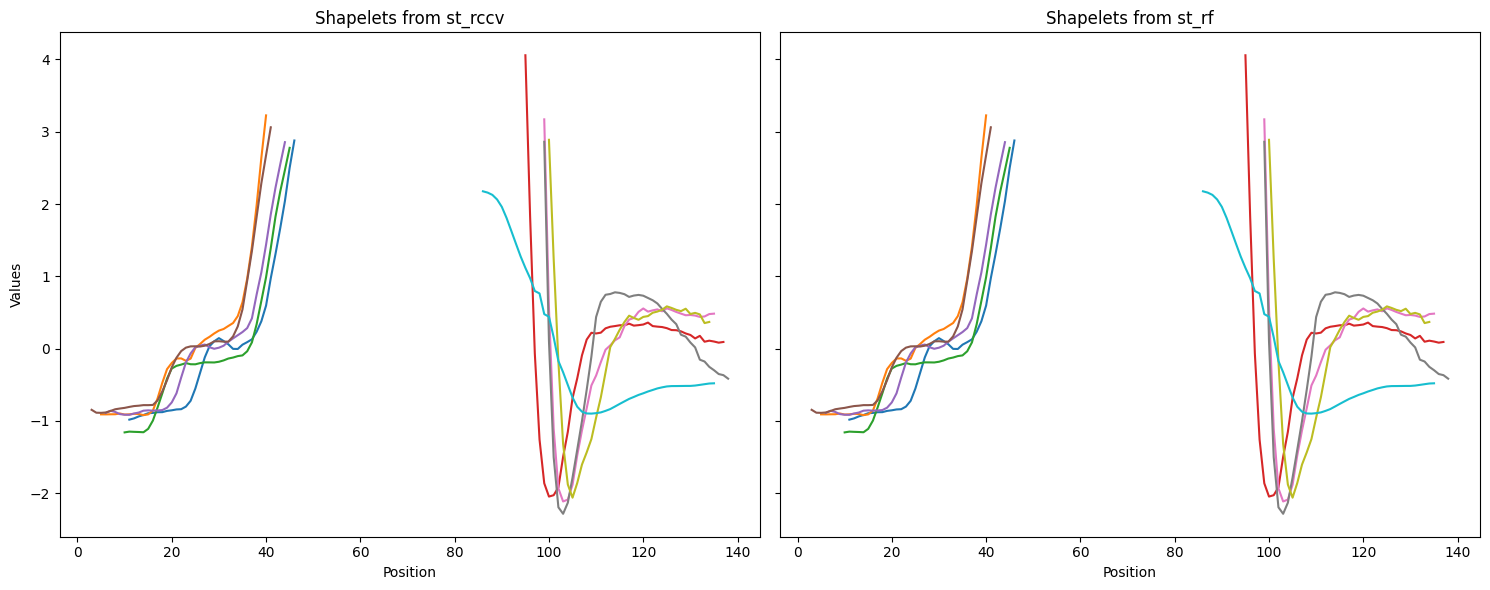

In [25]:
import matplotlib.pyplot as plt

# First set of shapelets (from st_rccv)
shapelets_rccv = st_rccv._transformer.shapelets
shapelet_vals_rccv = []
shapelet_pos_rccv = []

for shapelet in shapelets_rccv:
    shapelet_vals_rccv.append(shapelet[6])
    shapelet_pos_rccv.append(shapelet[2])

# Second set of shapelets (from st_rf)
shapelets_rf = rst_rf._transformer.shapelets
shapelet_vals_rf = []
shapelet_pos_rf = []

for shapelet in shapelets_rf:
    shapelet_vals_rf.append(shapelet[6])
    shapelet_pos_rf.append(shapelet[2])

# Create a figure with 2 subplots arranged horizontally
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot the first set of shapelets (st_rccv)
for i in range(len(shapelet_vals_rccv)):
    x_values = [x + shapelet_pos_rccv[i] for x in range(len(shapelet_vals_rccv[i]))]
    axs[0].plot(x_values, shapelet_vals_rccv[i])

axs[0].set_title("Shapelets from st_rccv")
axs[0].set_xlabel("Position")
axs[0].set_ylabel("Values")

# Plot the second set of shapelets (st_rf)
for i in range(len(shapelet_vals_rf)):
    x_values = [x + shapelet_pos_rf[i] for x in range(len(shapelet_vals_rf[i]))]
    axs[1].plot(x_values, shapelet_vals_rf[i])

axs[1].set_title("Shapelets from st_rf")
axs[1].set_xlabel("Position")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


We should see if they have the same shapelets, then compare how theyre ranked.

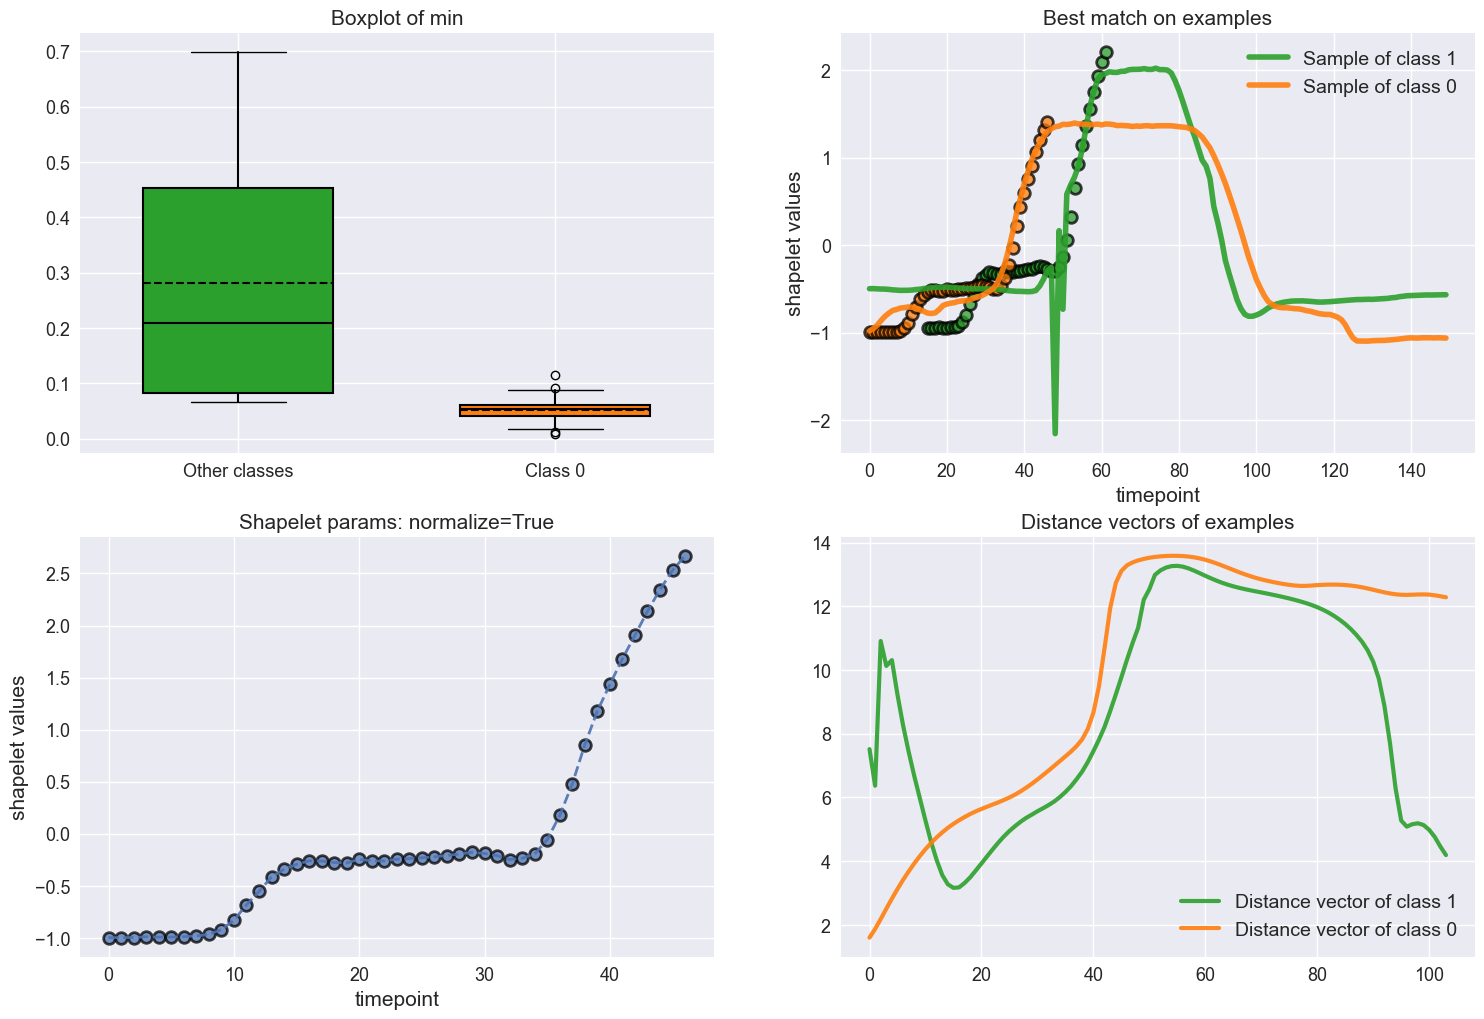

In [8]:
from aeon.visualisation import ShapeletClassifierVisualizer

st_rf_vis = ShapeletClassifierVisualizer(rst_rf)
id_class = 0
fig = st_rf_vis.visualize_best_shapelets_one_class(
    X_gun_test,
    y_gun_test,
    id_class,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

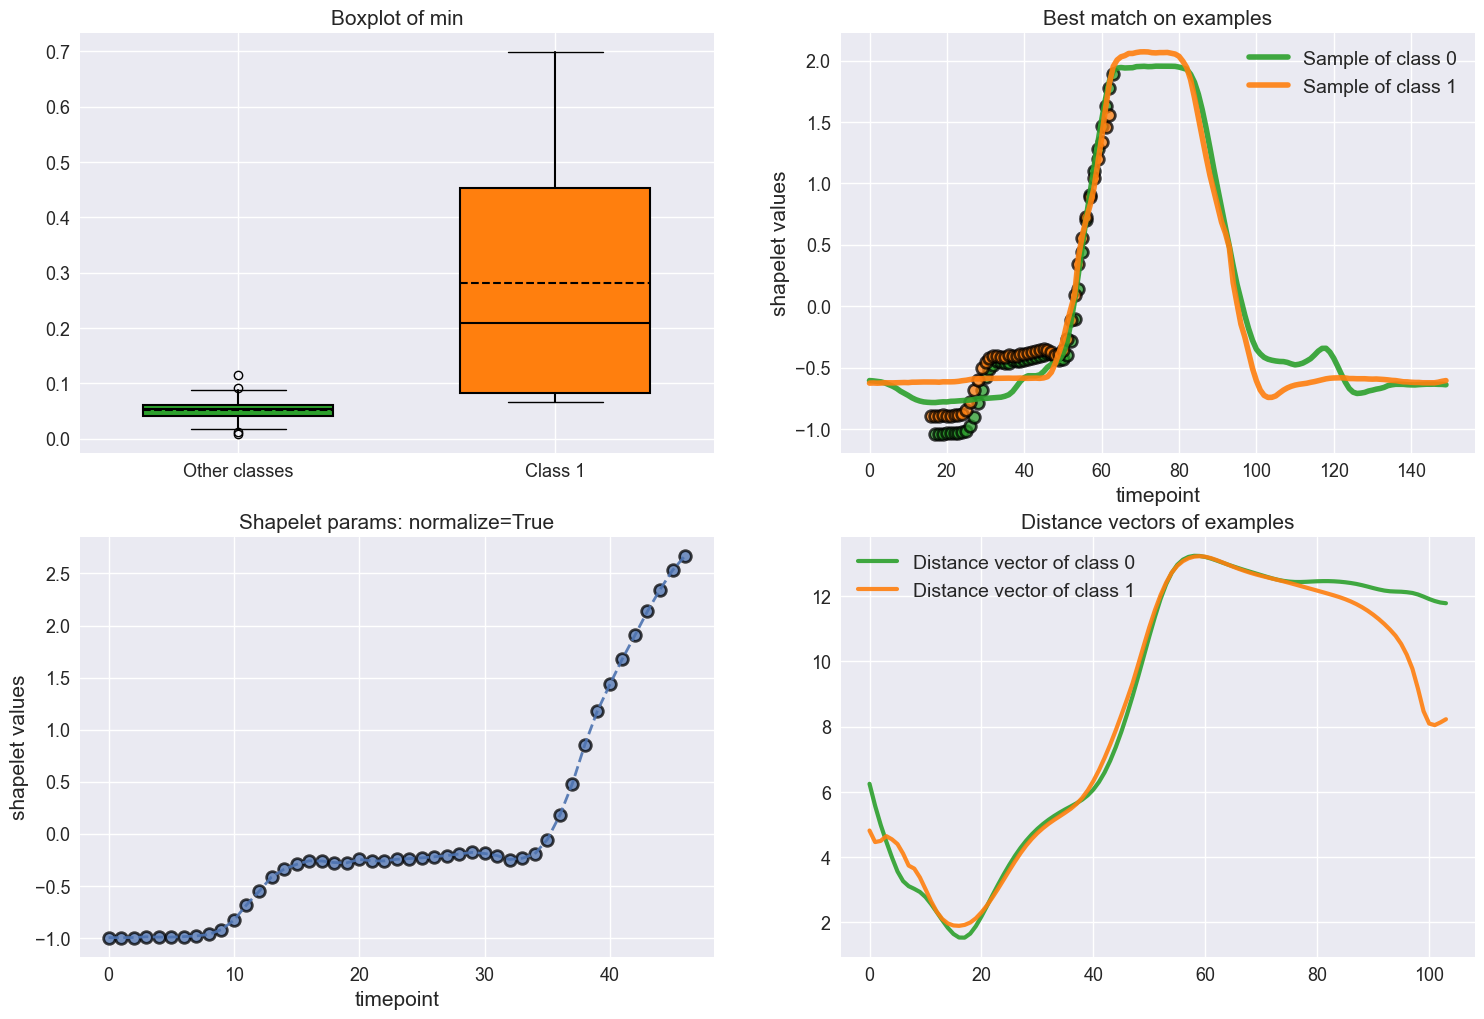

In [9]:
from aeon.visualisation import ShapeletClassifierVisualizer

st_rccv_vis = ShapeletClassifierVisualizer(st_rccv)
id_class = 1
fig = st_rccv_vis.visualize_best_shapelets_one_class(
    X_gun_test,
    y_gun_test,
    id_class,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

#### Random Dilated Shapelet Transform

This paper did not explore the Gunpoint problem, however the default parameters were defined as:

- proportion of z-normalised shapelets = 0.8
- number of shapelets to generate = 10000
- the set of possible lengths of shapelets = [11]
- The percentile boundaries used to sample the occurrence threshold: P1 = 5, P2 = 10

In [10]:
from aeon.transformations.collection.shapelet_based import RandomDilatedShapeletTransform
import time

shapelet_lengths = array = list(range(3, 151))

start_time = time.time()
rdst = RandomDilatedShapeletTransform(max_shapelets=10, shapelet_lengths = shapelet_lengths).fit(X_gun_train, y_gun_train)
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Time taken to fit: {elapsed_time:.4f} seconds")

pd.DataFrame(rdst.transform(X_gun_test)).head()

Time taken to fit: 57.9992 seconds


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,72.496494,15.0,0.0,52.354685,0.0,1.0,20.351334,43.0,0.0,3.109498,...,0.0,24.411689,37.0,0.0,40.831255,12.0,12.0,43.070965,10.0,0.0
1,16.208433,13.0,25.0,125.922444,0.0,0.0,67.864572,32.0,0.0,8.604146,...,0.0,56.222576,46.0,0.0,108.317971,4.0,0.0,40.468014,2.0,0.0
2,118.990562,0.0,0.0,98.597479,0.0,0.0,34.277228,68.0,0.0,21.961015,...,0.0,10.203430,30.0,10.0,119.711197,12.0,0.0,74.473478,0.0,0.0
3,58.917509,18.0,21.0,67.741381,0.0,0.0,28.243448,44.0,0.0,2.085433,...,6.0,33.013653,41.0,0.0,54.663957,12.0,9.0,27.161099,11.0,5.0
4,8.809778,13.0,26.0,111.003343,0.0,0.0,58.958797,46.0,0.0,4.112834,...,0.0,53.857240,44.0,0.0,95.472503,12.0,0.0,25.857124,4.0,7.0


Here, we are training a random forest classifier on the transformed data. The purpose is not to evaluate classification performance but to make use of the feature importance provided by the Random Forest to aid in comparing shapelets further on.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from aeon.classification.shapelet_based import RDSTClassifier
from sklearn.linear_model import RidgeClassifierCV

rdst_rf = RDSTClassifier(estimator=RandomForestClassifier(ccp_alpha=0.01), random_state=0).fit(
    X_gun_train, y_gun_train
)

rdst_rccv = RDSTClassifier(estimator=RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)), random_state=0).fit(
    X_gun_train, y_gun_train)

#### Scalable and Accurate Subsequence Transform

In [12]:
from aeon.transformations.collection.shapelet_based import SAST
import time

start_time = time.time()
sast = SAST().fit(X_gun_train, y_gun_train)
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Time taken to fit: {elapsed_time:.4f} seconds")

pd.DataFrame(sast.transform(X_gun_test)).head()

Time taken to fit: 0.1183 seconds


,0,1,2,3,4,5,6,7,8,9,...,22040,22041,22042,22043,22044,22045,22046,22047,22048,22049
0,1.342050e-03,0.000192,0.000330,0.001973,0.001385,0.027931,0.000008,3.497018e-03,0.014063,1.006971e-03,...,24.645668,19.159811,14.303392,52.797596,52.197628,51.719231,24.561058,19.096888,52.568790,51.971317
1,1.388890e-03,0.000009,0.001402,0.000175,0.003094,0.033847,0.016771,1.682806e-08,0.018346,3.091849e-07,...,79.862900,78.294067,76.966431,152.762177,152.715851,152.672668,80.266853,78.687523,153.196716,153.150818
2,1.610657e-03,0.000435,0.001333,0.001355,0.002661,0.004594,0.000037,2.533028e-04,0.003041,5.821094e-04,...,117.614853,119.692909,121.886177,58.650452,64.037949,70.553635,119.027550,121.203796,63.371902,69.782883
3,1.292802e-03,0.000006,0.000172,0.000255,0.001912,0.000045,0.000911,5.458379e-05,0.000778,8.211225e-04,...,11.704761,8.192752,5.530353,71.082253,70.949226,70.880089,11.709735,8.200663,70.940071,70.807579
4,4.031547e-07,0.000454,0.000014,0.001362,0.013141,0.000273,0.035521,4.843717e-04,0.000631,5.868596e-04,...,57.278015,54.745899,52.678223,126.695694,126.625687,126.585800,57.590355,55.046745,127.038269,126.969147


Here, we are training a random forest classifier on the transformed data. The purpose is not to evaluate classification performance but to make use of the feature importance provided by the Random Forest to aid in comparing shapelets further on.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from aeon.classification.shapelet_based import SASTClassifier
from sklearn.linear_model import RidgeClassifierCV

sast_rf = SASTClassifier(classifier=RandomForestClassifier(ccp_alpha=0.01), seed=0).fit(
    X_gun_train, y_gun_train
)


sast_rccv = SASTClassifier(classifier=RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)), seed=0).fit(
    X_gun_train, y_gun_train)

#### Random and Scalable Subsequence Transform

In [14]:
from aeon.transformations.collection.shapelet_based import RSAST
import time

start_time = time.time()
rsast = RSAST().fit(X_gun_train, y_gun_train)
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Time taken to fit: {elapsed_time:.4f} seconds")

pd.DataFrame(rsast.transform(X_gun_test)).head()

Time taken to fit: 1.9683 seconds


,0,1,2,3,4,5,6,7,8,9,...,4110,4111,4112,4113,4114,4115,4116,4117,4118,4119
0,0.000012,0.000075,0.000012,0.001252,0.000053,1.553106e-07,0.001872,0.005311,1.574099e-08,2.309860e-04,...,1.670796,43.714409,20.509773,3.090585,43.901752,3.443005,18.877438,20.747181,3.940429,23.692102
1,0.001561,0.000010,0.000074,0.000018,0.001051,1.208295e-04,0.000304,0.002083,2.120875e-04,1.534228e-04,...,1.221593,2.740358,2.775759,1.860711,2.369215,1.150254,0.476862,0.142806,0.481165,2.777501
2,0.001221,0.000076,0.000895,0.000772,0.001266,1.784831e-07,0.001682,0.019904,4.300760e-03,1.588329e-06,...,20.643702,73.781288,82.479973,87.077103,41.653908,76.780487,41.705078,39.704769,66.579880,81.080231
3,0.000112,0.000051,0.000006,0.000625,0.004613,2.093708e-05,0.000138,0.002232,8.743339e-05,8.620900e-07,...,0.889257,27.282755,19.985025,2.876013,30.865938,2.598322,17.990465,4.464840,2.829427,23.056068
4,0.000050,0.000130,0.000985,0.000777,0.002377,1.647595e-06,0.001690,0.003997,6.813438e-05,2.104385e-08,...,0.207803,1.028273,1.071875,1.531556,0.869544,1.625043,2.219437,0.276523,1.748716,1.011073


In [15]:
from sklearn.ensemble import RandomForestClassifier
from aeon.classification.shapelet_based import RSASTClassifier
from sklearn.linear_model import RidgeClassifierCV

rsast_rf = RSASTClassifier(classifier=RandomForestClassifier(ccp_alpha=0.01), seed=0).fit(
    X_gun_train, y_gun_train
)

rsast_rccv = RSASTClassifier(classifier=RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)), seed=0).fit(
    X_gun_train, y_gun_train)


# Interpreting the shapelets

### Random Shapelet Transform

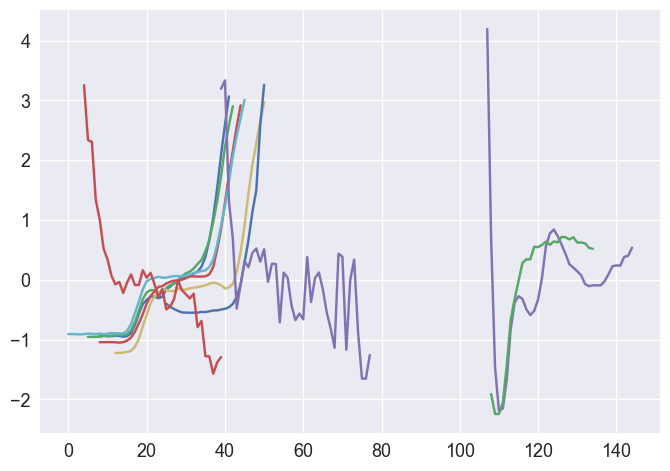

In [16]:
import matplotlib.pyplot as plt

shapelets = rst.shapelets
shapelet_vals = []
shapelet_pos = []

for shapelet in shapelets:
    shapelet_vals.append(shapelet[6])
    shapelet_pos.append(shapelet[2])

for i in range(len(shapelet_vals)):
    x_values = [x + shapelet_pos[i] for x in range(len(shapelet_vals[i]))]
    plt.plot(x_values, shapelet_vals[i])

# Show the plot
plt.show()

Text(0.5, 1.0, 'Distance vector of shapelet 3 on X')

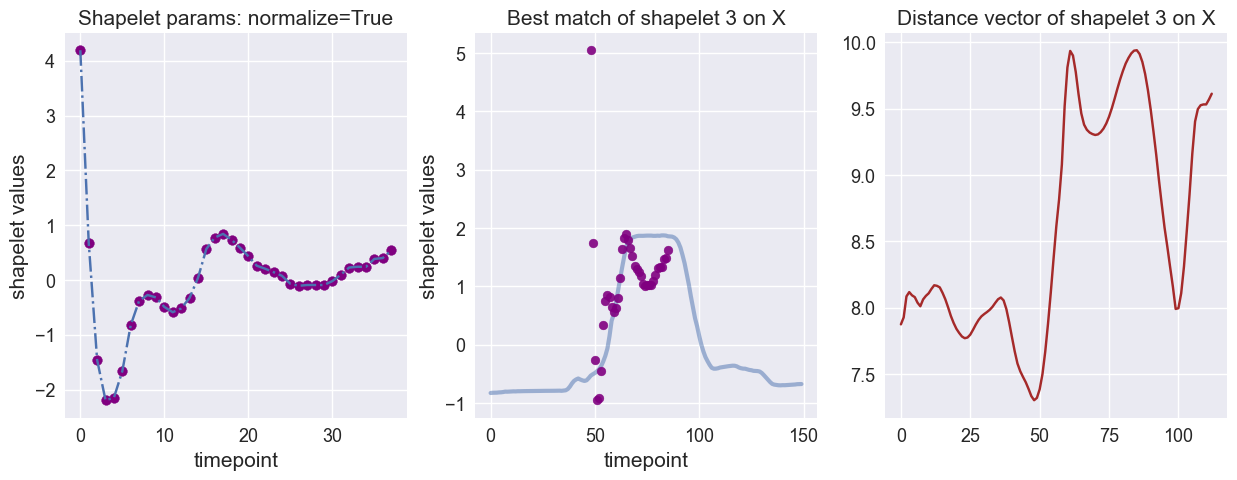

In [17]:
from matplotlib import pyplot as plt
from aeon.visualisation import ShapeletTransformerVisualizer

rst_vis = ShapeletTransformerVisualizer(rst)
id_shapelet = 3  # Identifier of the shapelet

fig_rst, ax_rst = plt.subplots(ncols=3, figsize=(15, 5))
rst_vis.plot(
    id_shapelet,
    ax=ax_rst[0],
    scatter_options={"c": "purple"},
    line_options={"linestyle": "-."},
)
rst_vis.plot_on_X(
    id_shapelet, X_gun_test[10], ax=ax_rst[1], line_options={"linewidth": 3, "alpha": 0.5}
)
ax_rst[1].set_title(f"Best match of shapelet {id_shapelet} on X")
rst_vis.plot_distance_vector(
    id_shapelet, X_gun_test[10], ax=ax_rst[2], line_options={"c": "brown"}
)
ax_rst[2].set_title(f"Distance vector of shapelet {id_shapelet} on X")

### Random Dilated Shapelet Transform

Text(0.5, 1.0, 'Distance vector of shapelet 2 on X')

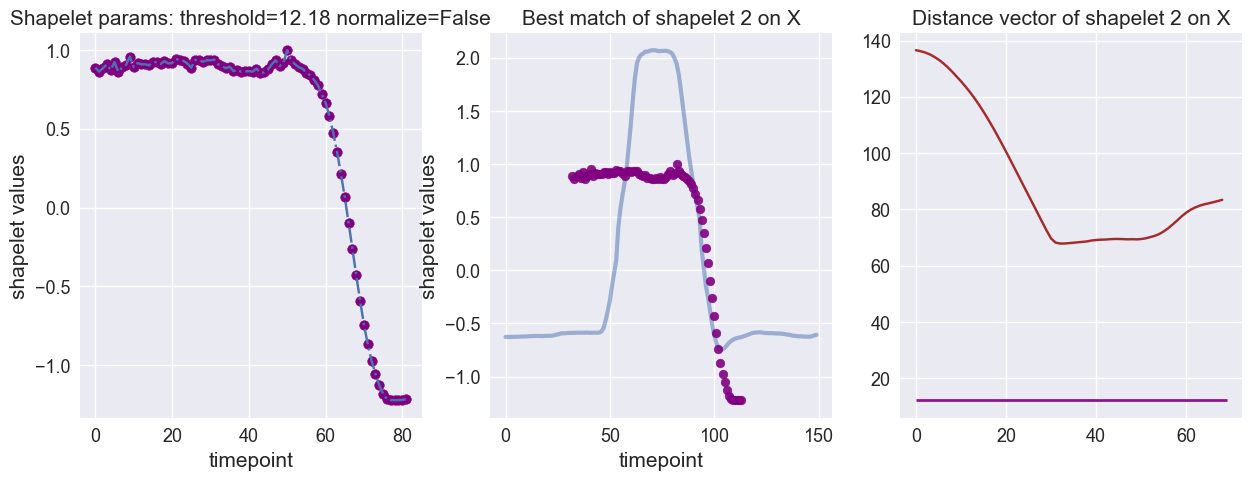

In [18]:
from matplotlib import pyplot as plt
from aeon.visualisation import ShapeletTransformerVisualizer

rdst_vis = ShapeletTransformerVisualizer(rdst)
id_shapelet = 2  # Identifier of the shapelet

fig_rdst, ax_rdst = plt.subplots(ncols=3, figsize=(15, 5))
rdst_vis.plot(
    id_shapelet,
    ax=ax_rdst[0],
    scatter_options={"c": "purple"},
    line_options={"linestyle": "-."},
)
rdst_vis.plot_on_X(
    id_shapelet, X_gun_test[1], ax=ax_rdst[1], line_options={"linewidth": 3, "alpha": 0.5}
)
ax_rdst[1].set_title(f"Best match of shapelet {id_shapelet} on X")
rdst_vis.plot_distance_vector(
    id_shapelet, X_gun_test[1], ax=ax_rdst[2], line_options={"c": "brown"}
)
ax_rdst[2].set_title(f"Distance vector of shapelet {id_shapelet} on X")

### SAST

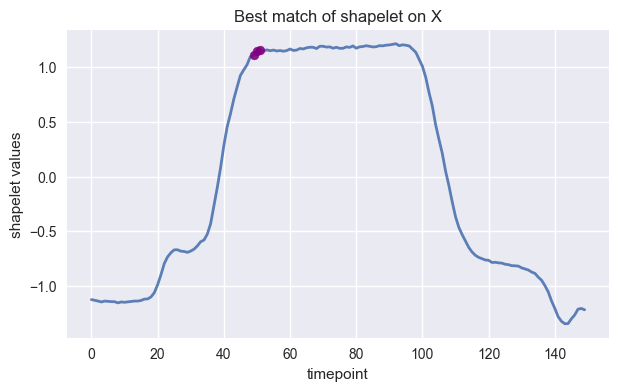

In [19]:
from aeon.visualisation import ShapeletTransformerVisualizer

sast_vis = ShapeletTransformerVisualizer(sast)
id_shapelet = 0  # Identifier of the shapelet

fig = sast_vis.plot_on_X(id_shapelet, X_gun_test[0], figure_options={"figsize": (7, 4)})

Text(0.5, 1.0, 'Distance vector of shapelet 0 on X')

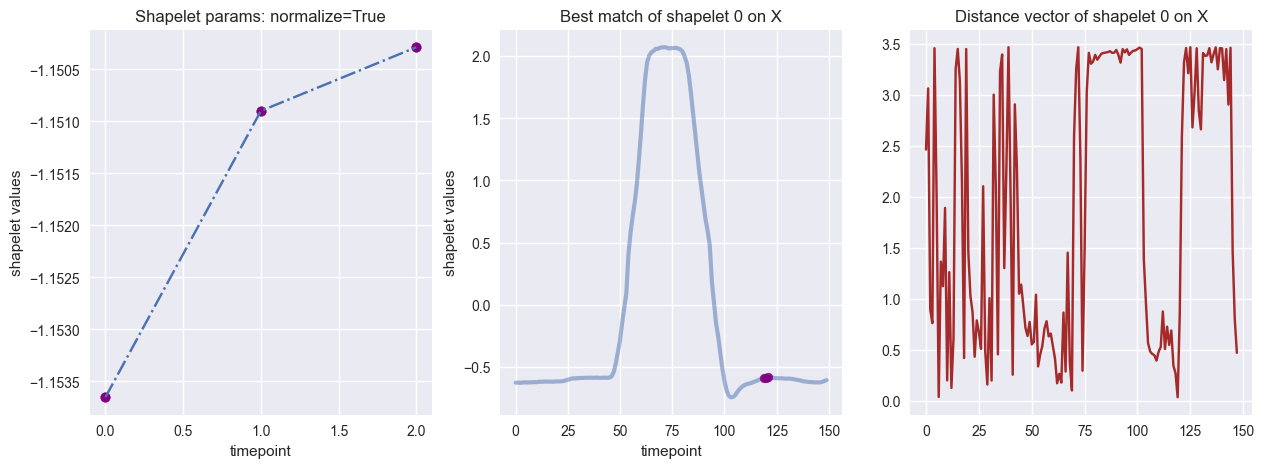

In [20]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
sast_vis.plot(
    id_shapelet,
    ax=ax[0],
    scatter_options={"c": "purple"},
    line_options={"linestyle": "-."},
)
sast_vis.plot_on_X(
    id_shapelet, X_gun_test[1], ax=ax[1], line_options={"linewidth": 3, "alpha": 0.5}
)
ax[1].set_title(f"Best match of shapelet {id_shapelet} on X")
sast_vis.plot_distance_vector(
    id_shapelet, X_gun_test[1], ax=ax[2], line_options={"c": "brown"}
)
ax[2].set_title(f"Distance vector of shapelet {id_shapelet} on X")

## Misc

In [21]:
from collections import Counter
shapelets = rst.shapelets
classes = []
for shapelet in shapelets:
    classes.append(shapelet[5])
Counter(classes)

# Here we can see that the RST has made 5 shapelets for each class
# docstring says Each class value will have its own max, set to n_classes / max_shapelets - enforcing same amount

Counter({'1': 5, '2': 5})

we can see that the NoGun class has a “dip” where the actor puts her hand down by
her side, and inertia carries her hand a little too far and she is forced to correct for it
(a phenomenon known as “overshoot”). In contrast, when the actor has the gun, she
returns her hand to her side more carefully, feeling for the gun holster, and no dip is
seen.

In [19], they identified that the most important shapelet for classification was when the actor lowered their arm; if they had no gun, a phenomenon called overshoot occurred and caused a dip in the data.
<br>
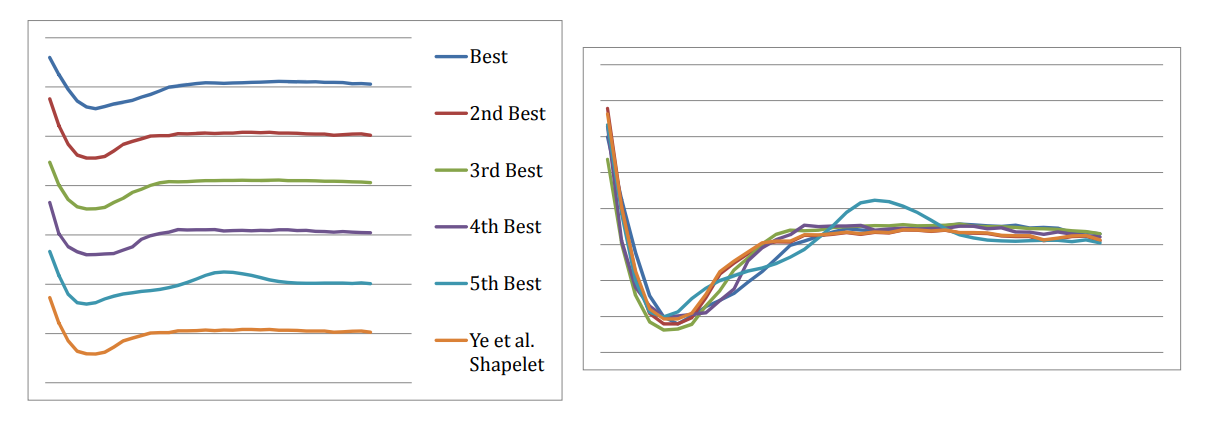
<br>
The shapelet decision tree trained by [19] contains a single
shapelet corresponding to the arm being lowered back into
position at the end of the series.

- To demonstrate that our
filter agrees with this and extracts the important information
from the data, we filtered the GunPoint data set using the
length parameters specified in the original paper to allow for
a fair comparison between the two methods. The top five
shapelets that we extracted are presented in Figure 5, along
with the shapelet reported by [19].
- The graphs in Figure 5 show that each of the top five
shapelets from our filter were very closely matched with
the shapelet from [19], reinforcing the notion that our filter
produces interpretable results. Furthermore, if we extract
the top ten shapelets from the filter we can gain even further
insight. Figure 6 shows that the top ten shapelets form two
distinct clusters. Interestingly, the shapelets to the left of the
figure correspond to the moments where the arm is lifted and
are instances where there is a gun. These shapelets could
correspond to the subtle extra movements required to lift the
prop, aiding classification by providing more information.
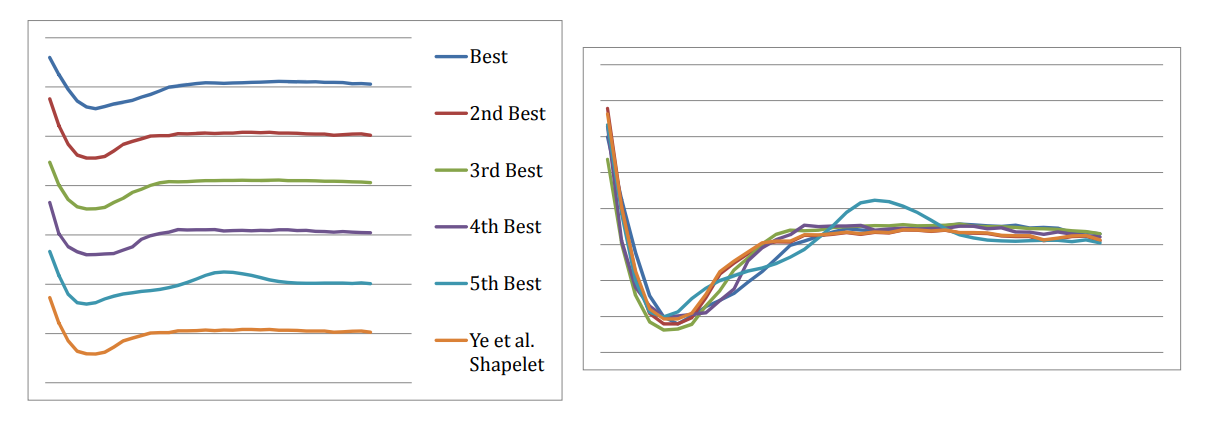

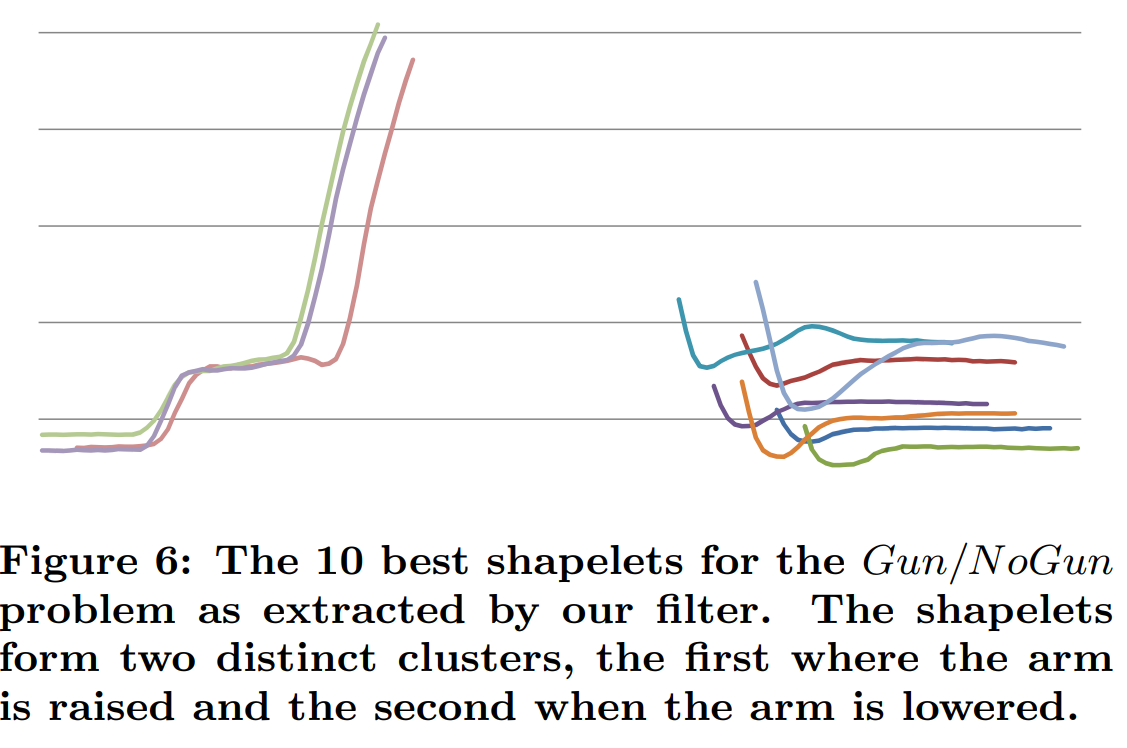



In the case where subsampling completely
removes one actor from the training data, the performance on the test set, where the two
actors are present, could be reduced.